<a href="https://colab.research.google.com/github/pinkett35/Quantum-KNN/blob/main/Quantum_knn_classfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qiskit

In [3]:
##Importing libraries 
import numpy as np
from keras.datasets import mnist
from qiskit import *
from matplotlib import pyplot as plt 
import tensorflow as tf
from qiskit.circuit import QuantumRegister,ClassicalRegister,QuantumCircuit
from qiskit.extensions import UnitaryGate
#import tensorflow_quantum as tfq
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import shutil
import os
import time
import sys
import PIL
#from PIL import Image 
from matplotlib import cm 
import functools
import collections

Step #1 Load data set as quantum information

Number of filtered training examples: 12049
Number of filtered test examples: 1968
True
True
Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338
New x values [[[[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.33333334]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.9882353 ]
   [0.        ]]

  [[0.        ]
   [0.6745098 ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.99607843]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.99607843]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.19215687]
   [0.        ]]

  [

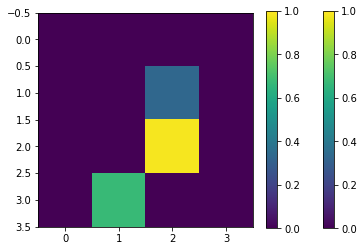

In [4]:
#Global variables 
orig_img_size = 28
img_size = 16
interest_num = [0, 1]
#Loading the dataset 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0



def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()
##Tuple of nd.arrays 
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    print("New x values", np.array(new_x))
    return np.array(new_x), np.array(new_y)


x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Auto encode data onto quantum states to prepare for quantum circuit. 

In [5]:
###Auto-encoder 
##Encoding class to encode quantum data 
class EncodeUnitaryMatrix():
    def __init__(self,data):
        self.data = data
    # Check if a matrix is unitary using this function
    def is_unitary(self,m):
        return np.allclose(np.eye(len(m)), m.dot(m.T.conj()))
    def to_unitary_matrix(self):
        qm = self.toQuantumMatrix(self.data)
        qv =self.toQuantumData(self.data)
        self.data_matrix = np.array(qm)
        self.data_vector = np.array(qv)
    # Converting classical data to quantum data
    def toQuantumData(self,data):
        input_vec = data.copy().ravel()
        vec_len = input_vec.shape[0]
        input_matrix = np.zeros((vec_len, vec_len))
        input_matrix[0] = input_vec
        input_matrix = np.float64(input_matrix.transpose(0, 1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = np.dot(u, v)
        output_matrix = output_matrix
        output_data = output_matrix[0, :]
        print(output_data)
        return output_data
    # Converting classical data to quantum matrix
    def toQuantumMatrix(self,data):
        input_vec = data.flatten()
        vec_len = input_vec.shape[0]
        input_matrix = np.zeros((vec_len,vec_len))
        input_matrix[0] = input_vec
        input_matrix = input_matrix.T
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = np.dot(u, v)
        return output_matrix
    def get_data(self):
        return self.data
    def get_unitary_gate(self):
        self.to_unitary_matrix()
        return self.data_matrix
    def get_quantum_data(self):
        self.to_unitary_matrix()
        return self.data_vector
data = EncodeUnitaryMatrix(x_train_nocon[0])
conv_data_matrix,conv_data_statevector = (data.get_unitary_gate(),data.get_quantum_data)


[0.         0.         0.         0.         0.         0.
 0.26837393 0.         0.         0.         0.79564974 0.
 0.         0.54306254 0.         0.        ]


In [ ]:
# Load data, resize data , call Sam's encoded function for the quantum circuit, use swap test at

Applying RY gate to circuit. 

In [6]:
def RY(circuit,values):
  for i,val in enumerate(values):
    circuit.ry(val,i+1)

def CRY(circuit,values):
  for i in range(len(values)):
    if i == len(values):
      circuit.cry(values[-1],i+2, i+2)
    circuit.cry(values[i],i+1, i+2)

Apply CRY gate to circuit.  

In [7]:
class QuantumConvolutionalState():
    def __init__(self, layer_count, qubit_count):
        self.state = None
        self.layer_count = layer_count
        self.qubit_count = qubit_count
        self.initialize_random_state()

    def initialize_random_state(self):
        self.state = [[np.random.rand()*np.pi for _ in range(self.qubit_count)] for _ in range(self.layer_count)]

    def get_states(self):
        return self.state

    def fwd_diff(self,layer_index,gate_index):
        temporary_list = copy.deepcopy(self.state)
        print(temporary_list)
        temporary_list[layer_index][gate_index] += 0.5*np.pi
        return temporary_list

    def bck_diff(self,layer_index,gate_index):
        temporary_list = copy.deepcopy(self.state)
        print(temporary_list)
        temporary_list[layer_index][gate_index] -= 0.5*np.pi
        return temporary_list

    def differentiate(self, layer_index, gate_index):
        return self.bck_diff(layer_index, gate_index), self.fwd_diff(layer_index, gate_index)

In [ ]:
import qiskit
import copy 
from qiskit.extensions import XGate, UnitaryGate

#data being applied to encode unitary matrix
data = EncodeUnitaryMatrix(x_train_nocon[0])

##data matrix 
conv_data_matrix,conv_data_statevector = (data.get_unitary_gate(),data.get_quantum_data)
##Shape of data matrix 
#print(conv_data_matrix.shape)

###Take a data point 
#Variable bank (random array multiplied by pi, 16 by 16)
variables = [np.random.rand()*np.pi for _ in range(16)]


##Takes a data point and matrix and applies a circuit 
def encode_circuit_init(variables, conv_data_matrix):
#Qubit register 
  qubits = QuantumRegister(9)
#Classical register
  cbits = ClassicalRegister(1)
## Builds the Circuit
  circ = QuantumCircuit(qubits)
  circ.add_register(cbits)
##Appending the unitary gate to the circuit 
  circ.append(UnitaryGate(conv_data_matrix),qubits[1:5])
  circ.append(UnitaryGate(conv_data_matrix),qubits[5:9])
##Applying the RY and CRY function
  RY(circ, variables[0:4])
  CRY(circ,variables[5:9])
##Resetting the first and second qubit 
  circ.reset(1)
  circ.reset(2)
##Applying the RY and CRY function
  RY(circ, variables[8:12])
  CRY(circ, variables[12:16])
  circ.h(0)
  sim = Aer.get_backend('qasm_simulator')
  [circ.cswap(0,i+1,i+5) for i in range(4)]
  circ.h(0)
  circ.measure(0,0)
  return circ

##print(circ.draw())
encode_circuit_init(variables, conv_data_matrix)

#Variable for simulator
simulator = Aer.get_backend('qasm_simulator')


##Function : Calculates Quantum Fidelity from circuit and data matrix
def get_probabilities(circ,counts=7500):
    job = execute(circ, backend = simulator , shots=counts)
    results = job.result().get_counts(circ)
    try:
        prob = results['0']/(results['1']+results['0'])
        prob = (prob-0.5)
        if prob <= 0.005:
            prob = 0.005
        else:
            prob = prob*2
    except:
        prob = 1
    return prob

#Variables to store result from get_prob function 
Q_fi = get_probabilities(encode_circuit_init(variables, conv_data_matrix))

#Q_fi = get_probabilities(encode_circuit_init(theta, conv_data_matrix))


##Function purpose: Loops over data points and retrieves gradient from circuit and data matrix  
def LoopTraining(circuit, conv_data_matrix):
  #Looping 50 times 
 for i in range(0, 50):
   #Loop over data points
   for data in conv_data_matrix: 
  ## Loops over variable bank
    for j in range(len(variables)):
        theta = copy.deepcopy(variables)

      ##Build circuit 1 with theta variables measure fidelity
        circuit1 = get_probabilities(encode_circuit_init(theta, conv_data_matrix)) + np.pi/ 2

      ##Build circuit 2 measure fidelity 
        circuit2 = get_probabilities(encode_circuit_init(theta, conv_data_matrix)) - np.pi/ 2

      ##Gradient = fidelity(circuit 1) - fidelity(circuit 2)
        gradient = (circuit1 - circuit2) / 2

    ##Variables [i] += gradient * 0.01
        theta[i] += gradient * 0.01 


print(LoopTraining(encode_circuit_init(variables, conv_data_matrix), conv_data_matrix))


In [ ]:
class QuantumEncoder:
    def __init__(self):
        self.data = None
        self.states = None
        self.qubits = None
        self.uninit_layers = []

    def __init__(self, quantum_matrix,states):
        # make sure that the quantum_matrix is properly unitary
        #assert np.isclose(np.matmul(quantum_matrix, np.transpose(quantum_matrix)), np.identity(len(quantum_matrix)))
        self.mat = quantum_matrix # quantum data that is already unitary
        self.set_dims() # loads self.qubits with appropriate value
        self.states = states
        self.inp = None
        self.circ = None
        self.c_reg = None
        self.uninit_layers = []
        self.circ = None # circuit
        self.c = 1  # one classical bit
        self.inp = None # array of input qubits
        self.c_reg = None
        self.make_circuit() # initializes the circuit
        self.q_encode() # after setting up, finally, encode


    def set_dims(self):
        """sets dimensions of input qubit amount for the circuit. length(inp) == qubits"""
        dims = len(self.mat) # dimensionality of data
        # added len of random states, plus one ancilla for swap-tets
        in_q = int(np.log2(dims))
        self.qubits = in_q*2 + 1 # Number of qubits = log2(Dimensionality of data) (could be a decimal number)

    def make_circuit(self):
        """creates quantum and classical register  & circuit w/ appropriate qubits"""
        self.inp = QuantumRegister(self.qubits, "in_qbit")
        self.circ = QuantumCircuit(self.inp) #
        # Add classical register
        self.c_reg = ClassicalRegister(self.c, "reg")
        self.circ.add_register(self.c_reg)

    def RY(self,states):
        """performs RY on all initial states"""
        for i in range(1, len(states) + 1):
            self.circ.ry(states[i-1], self.inp[i])

    def CRY(self,states):
        """performs controlled ry chain on all qubits, creates cycle.
            i.e. cry from qubit 5->1, 1->2, etc."""
        inp = self.inp
        for i in range(1, len(states) + 1):
            if i == len(states): # if last state, conrol first qubit, ignore ancilla
                self.circ.cry(states[i-1], inp[i], inp[1])
                continue
            self.circ.cry(states[i-1], inp[i], inp[i+1])

    def swap_test(self):
        """performs cswap on each"""
        inp = self.inp
        stretch = self.qubits//2
        self.circ.h(inp[0])
        for i in range(1, stretch+1):
            self.circ.ccx(inp[i], inp[i+stretch], inp[0])
        self.circ.h(inp[0])

    def addLayer(self,layer_style):
        if layer_style == "RY" or "CRY":
            self.uninit_layers.append(layer_style)
        else:
            raise("Not a valid layer")

    def initializeCircuit(self):
        for index,layer in enumerate(self.uninit_layers):
            if layer == "RY":
                self.RY(self.states[index])
            if layer == "CRY":
                self.CRY(self.states[index])

    def q_encode(self):
        """performs RY, controlled RY and then RY on each state, followed by the swap_test"""
        #print(self.qubits, ' qubits')
        self.addLayer("RY")
        self.addLayer("CRY")
        self.addLayer("RY")
        self.initializeCircuit()
        self.circ.append(UnitaryGate(self.mat, label="Input"), self.inp[5:9])
        self.swap_test()
#       return self.circ, self.qubits

    def update_states(self,new_state):
        assert type(self.states==new_state,"Not the same type of data")
        self.states = new_state

    def get_states(self):
        return self.states